### import libraries ###

In [134]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping


### main function
    The main function below drives the entire code. 
    It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.

In [135]:
def main():
    df = pd.read_csv('cover_data.csv')
    # EDA
    EDA(df)
    # Data processing
    X_train, X_test, Y_train, Y_test = dataProcessing(df)
    # Build the model
    model = modelBuilding(X_train)
    model.summary()
    # model training
    EPOCHS = 20
    BATCH_SIZE = 1024
    es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        Y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[es],
                        validation_split=0.2,
                        verbose=1)
    
    # Evaluate the model
    modelEval(X_test, Y_test, history)
    # Visualize and report


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

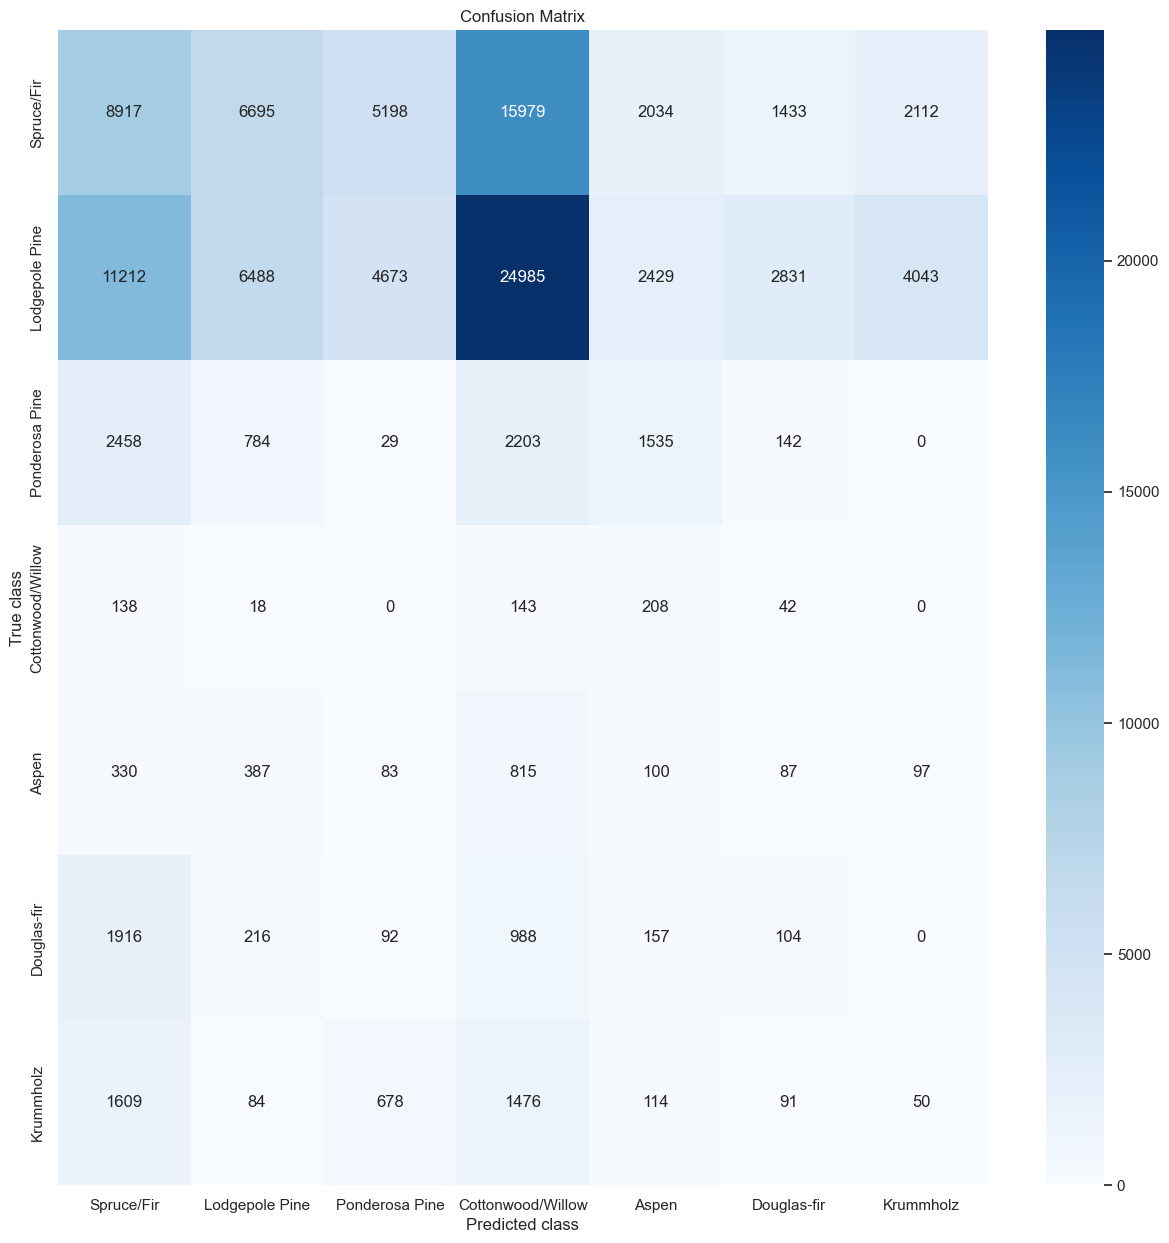

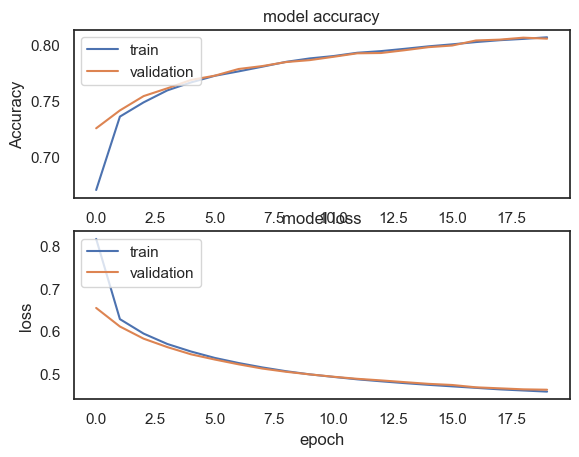

In [136]:
if __name__ == '__main__':
    main()


### Helper Functions

In [137]:
EDA(df)
def EDA(df):
    '''
    Data Exploring and Preprocessing (EDA)
    To find insights to help with Data cleaning/preparation/transformation, which will ultimately be used into a machine learning algorithm. The following steps are followed:
    1. Print headings of the dataset
    2. Print info of dataset
    3. Count class numbers: binary vs multi-class
    '''
    df.head()
    print(df.info())
    print(Counter(df['class']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [138]:
def dataProcessing(df):
    '''
    preprocess the datasets by spliting datasets to train and test sets, standardize numerical features, and transfomr multiclass labels to binary vectors
    '''
    features = df.iloc[:,0:-1]
    labels = df.iloc[:,-1]
    # split datasets to train and test
    X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2,random_state=42, stratify=labels )
    # standardize numerical values
    numerical_features = features.select_dtypes(include=['float64','int64'])
    numerical_columns = numerical_features.columns
    ct = ColumnTransformer([("numeric",StandardScaler(),numerical_columns)])
    # apply standardization to training and testing features
    X_train_scaled = ct.fit_transform(X_train)
    X_test_scaled = ct.fit_transform(X_test)

    ## Prepare labels for multi-class classification
    le = LabelEncoder()
    Y_train = le.fit_transform(Y_train.astype(str))
    Y_test = le.transform(Y_test.astype(str))
    # transform labels into a binary vector
    Y_train = to_categorical(Y_train)
    Y_test = to_categorical(Y_test)

    print(X_train_scaled)
    print(Y_train)
    return X_train_scaled, X_test_scaled, Y_train, Y_test


In [139]:
def modelBuilding(X_train):
    '''
    Design the neural network model
    '''
    model = Sequential()
    #input layer
    model.add(InputLayer(input_shape = (X_train.shape[1],)))
    # hidden layer
    hidden_layer = Dense(64,activation='relu')
    model.add(hidden_layer)
    # output layer
    model.add(Dense(7,activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [140]:
def modelEval(X_test,Y_test,history):

    y_estimate = model.predict(X_test, verbose = 0)
    y_estimate = np.argmax(y_estimate, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_true, y_estimate, target_names=class_names))
    
    plot_heatmap(class_names, y_estimate, y_true)
    #print(classification_report(y_true, y_estimate))

    fig = plt.figure()
    # plot loss and accuracy over each epoch

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')


    # Plot loss and val_loss over each epoch
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [141]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    # heatmapfig.savefig(f'../output/confusion_matrix.png')